<a href="https://colab.research.google.com/github/appliedcode/mthree-c422/blob/mthree-c422-dipti/Exercises/Mid-training-Assignments/Team-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ETL Lab Exercise: Wine Quality Dataset

## Problem Statement

In this exercise, you will build an end-to-end ETL (Extract-Transform-Load) pipeline using the public "Wine Quality" dataset from the UCI Machine Learning Repository. All work will be done in Google Colab using only local resources.

---

## Tasks

### 1. Extract
- **Download:**  
  Download the "Wine Quality - Red" dataset directly from this URL:  
  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
- **Load:**  
  Load the CSV file into a pandas DataFrame, specifying the separator (`;`).

### 2. Transform
- **Clean:**  
  - Check for and handle any missing or anomalous values.
  - Rename columns for better readability, if desired.
- **Feature Engineering:**  
  - Classify each wine as "High Quality" if its `quality` score is 7 or higher, otherwise "Low/Medium Quality."
  - Normalize numerical features for further analysis.
  - (Optional) Create a feature representing the sum of acidity levels (`fixed acidity` + `volatile acidity`).

### 3. Load
- **SQLite Storage:**  
  Store the transformed DataFrame into a local SQLite database in Colab.
- **SQL Queries:**  
  - Count the number of high and low/medium quality wines.
  - Find the average alcohol percentage by wine quality group.
  - Identify the top 5 wines (rows) with the highest alcohol content.

---

## Constraints

- Use only pandas, Python standard library, and SQLite—all within Google Colab.
- Do **not** use any external or cloud database services.

---

## Dataset

- **Wine Quality Red CSV:**  
  [https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv)

---

## Example Challenge Questions

- What percentage of red wines are classified as high quality?
- Which parameter most strongly correlates with wine quality in this sample?
- What is the distribution of alcohol content among different quality groups?

---

**Expected Outcome:**  
You’ll successfully practice ETL skills on a benchmark dataset: from real-world-style data ingestion, cleaning, and enrichment, to local SQL storage and querying for analytics—all inside Colab.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import sqlite3
import urllib.request

# Download the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
file_path = "winequality-red.csv"
urllib.request.urlretrieve(url, file_path)

# Load with the correct separator
df = pd.read_csv(file_path, sep=';')

In [ ]:
df


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [ ]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Rename columns
df.columns = df.columns.str.replace(' ', '_').str.lower()

# Feature engineering: classify wine quality
df['quality_label'] = df['quality'].apply(lambda q: 'High Quality' if q >= 7 else 'Low/Medium Quality')

# Normalize numerical columns (min-max scaling)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

numerical_cols = df.select_dtypes(include='number').columns.drop('quality')
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Create additional feature: total_acidity = fixed_acidity + volatile_acidity
df['total_acidity'] = df['fixed_acidity'] + df['volatile_acidity']

Missing values:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [ ]:
conn = sqlite3.connect("wine_quality.db")
df.to_sql("wine_data", conn, if_exists="replace", index=False)

1599

In [ ]:
# 1. Count of high and low/medium quality wines
query1 = """
SELECT quality_label, COUNT(*) as count
FROM wine_data
GROUP BY quality_label;
"""
print("\nCount by quality label:")
print(pd.read_sql_query(query1, conn))


Count by quality label:
        quality_label  count
0        High Quality    217
1  Low/Medium Quality   1382


In [ ]:
# 2. Average alcohol content by wine quality
query2 = """
SELECT quality_label, ROUND(AVG(alcohol), 3) as avg_alcohol
FROM wine_data
GROUP BY quality_label;
"""
print("\nAverage alcohol by quality:")
print(pd.read_sql_query(query2, conn))


Average alcohol by quality:
        quality_label  avg_alcohol
0        High Quality        0.480
1  Low/Medium Quality        0.285


In [ ]:
# 3. Top 5 wines by alcohol content
query3 = """
SELECT *
FROM wine_data
ORDER BY alcohol DESC
LIMIT 5;
"""
print("\nTop 5 highest alcohol wines:")
print(pd.read_sql_query(query3, conn))

# Close the connection
conn.close()


Top 5 highest alcohol wines:
   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0       1.000000          0.164384         0.65        0.452055   0.140234   
1       0.053097          0.150685         0.00        0.061644   0.063439   
2       0.053097          0.150685         0.00        0.061644   0.063439   
3       0.371681          0.232877         0.45        0.116438   0.088481   
4       0.035398          0.205479         0.24        0.075342   0.080134   

   free_sulfur_dioxide  total_sulfur_dioxide   density        ph  sulphates  \
0             0.295775              0.229682  0.552863  0.188976   0.305389   
1             0.366197              0.201413  0.112335  0.740157   0.275449   
2             0.366197              0.201413  0.112335  0.740157   0.275449   
3             0.084507              0.042403  0.339941  0.456693   0.275449   
4             0.253521              0.155477  0.119677  0.771654   0.245509   

    alcohol  quality      

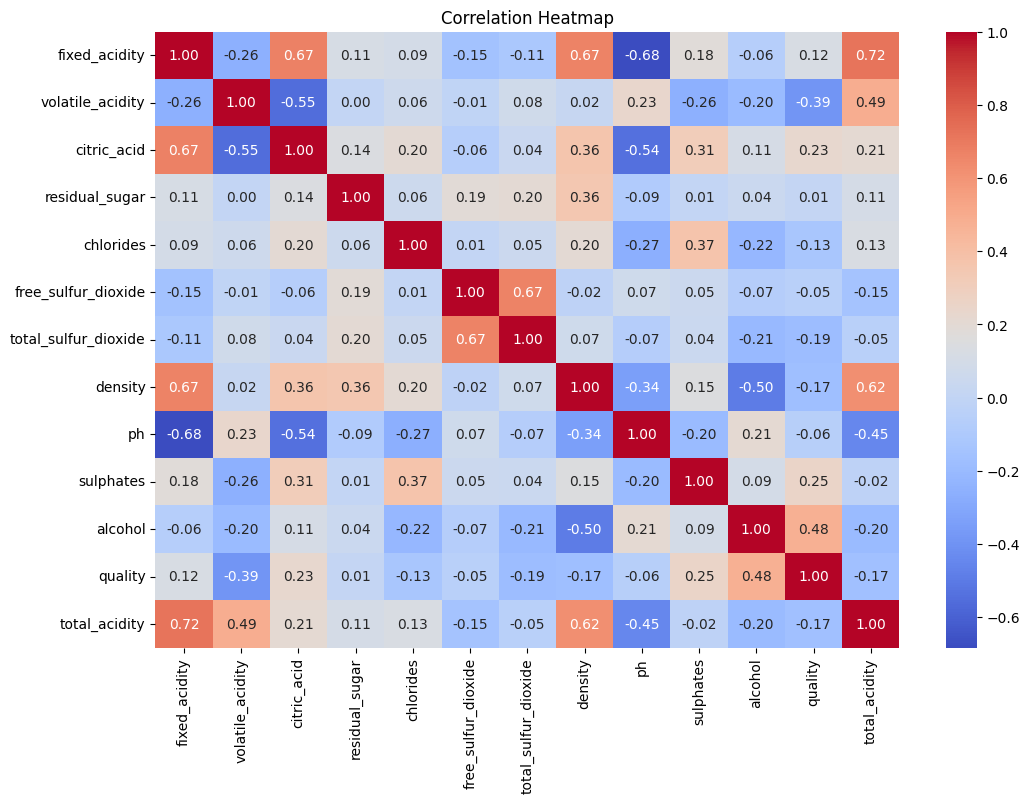

In [ ]:
"""plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='quality_label')
plt.title("Count of Wine Quality Labels")
plt.xlabel("Quality Label")
plt.ylabel("Count")
plt.show()
"""
"""# Histogram of alcohol content
plt.figure(figsize=(8, 4))
sns.histplot(df['alcohol'], kde=True)
plt.title("Distribution of Alcohol Content")
plt.xlabel("Alcohol")
plt.ylabel("Frequency")
plt.show()"""

"""# Boxplot of alcohol by quality label
plt.figure(figsize=(6, 4))
sns.boxplot(x='quality_label', y='alcohol', data=df)
plt.title("Alcohol Content by Quality Label")
plt.show()"""

# Correlation Heatmap (exclude non-numeric columns)
plt.figure(figsize=(12, 8))
sns.heatmap(df.drop('quality_label', axis=1).corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
total = len(df)
high = (df['quality_label'] == 'High Quality').sum()
print(f"High Quality Wines: {100 * high / total:.2f}%")


High Quality Wines: 13.57%


In [ ]:
# Select only numeric columns
df_numeric = df.select_dtypes(include='number')

# Compute correlation
correlation = df_numeric.corr()['quality'].sort_values(ascending=False)
print("Top correlated features:\n", correlation)


Top correlated features:
 quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric_acid             0.226373
fixed_acidity           0.124052
residual_sugar          0.013732
free_sulfur_dioxide    -0.050656
ph                     -0.057731
chlorides              -0.128907
total_acidity          -0.168739
density                -0.174919
total_sulfur_dioxide   -0.185100
volatile_acidity       -0.390558
Name: quality, dtype: float64


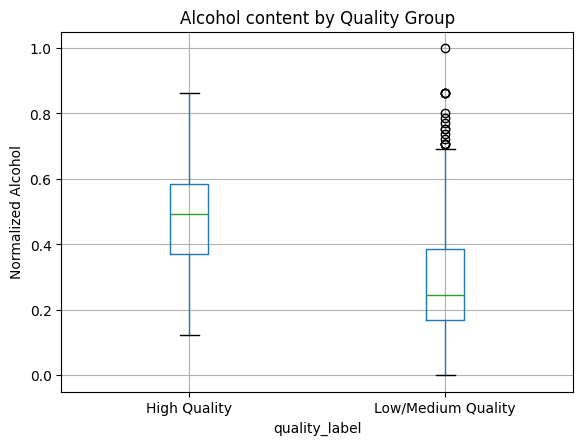

In [ ]:
import matplotlib.pyplot as plt

df.boxplot(column='alcohol', by='quality_label')
plt.title("Alcohol content by Quality Group")
plt.suptitle("")
plt.ylabel("Normalized Alcohol")
plt.show()
